In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [207]:
import torch
import numpy as np

import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from IPython.display import HTML
import matplotlib.animation as animation

import sac
import envs
import utils
import envs.walker_utils as walker_utils

from rnet.model import RNetModel
from rnet.memory import RNetMemory

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [322]:
logs_dir = '/checkpoint/linamezghani/offline-gcrl/logs/'

exp_name = "20220512-061832_walker_graph_sig-reward-rs1.0-lr0.0005-bs512-alpha0.005-gamma0.9-unsup-graph_sig-temp3"

%ls '{logs_dir}{exp_name}/agent'

checkpoint_0.pth     checkpoint_200.pth  checkpoint_500.pth  checkpoint_800.pth
checkpoint_100.pth   checkpoint_300.pth  checkpoint_600.pth  checkpoint_900.pth
checkpoint_1000.pth  checkpoint_400.pth  checkpoint_700.pth


In [323]:
ckpt = 700
ckpt_path = f'{logs_dir}{exp_name}/agent/checkpoint_{ckpt}.pth'

In [324]:
tmp_path = f"{logs_dir}/multirun/{exp_name}"
cfg_path = f"{tmp_path}/{os.listdir(tmp_path)[0]}/.hydra/config.yaml"

cfg = OmegaConf.load(cfg_path)

cfg.env.max_episode_steps=100

cfg.env.random_start_pos = False

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)

In [325]:
vis_cfg = cfg.copy()
env = envs.make_env(cfg.env, space_info)

if cfg.env.obs.type == 'vec':
    vis_cfg.env.obs.type = 'rgb'
    space_info_rgb = utils.get_space_info(vis_cfg.env.obs, vis_cfg.env.action_dim)
vis_env = envs.make_env(vis_cfg.env, space_info_rgb)

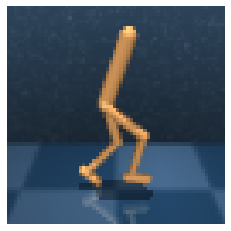

In [326]:
obs = vis_env.reset()
plt.imshow(obs['obs'].transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [327]:
device=torch.device("cuda:0")
space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)
agent = sac.SAC(cfg.sac, space_info, device)

agent.load_checkpoint(ckpt_path, evaluate=True)

Loading models from /checkpoint/linamezghani/offline-gcrl/logs/20220512-061832_walker_graph_sig-reward-rs1.0-lr0.0005-bs512-alpha0.005-gamma0.9-unsup-graph_sig-temp3/agent/checkpoint_700.pth


In [328]:
model = RNetModel(cfg.rnet.model, space_info)
model.to(device)
model.load(f'{logs_dir}{exp_name}/model.pth')
model.eval()

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=15, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [344]:
def get_reward(model, state):
    obs = torch.from_numpy(state['obs']).float().to(device).unsqueeze(0)
    goal = torch.from_numpy(state['goal_obs']).float().to(device).unsqueeze(0)
    return model(obs, goal, batchwise=True)[:, 0].item()

def generate_episode_walker(env, goal_idx=None, vis=True, plot=False):
    video = []
    num_steps = cfg.env.max_episode_steps//cfg.env.action_repeat
    if plot:
        to_plot = {x: np.zeros(num_steps) for x in ['rnet_val', 'oracle_dist']}

    _ = env.reset(goal_idx=goal_idx)
    goal_idx = env.goal_idx if goal_idx is None else goal_idx

    if 'rgb_obs' in env.goals:
        goal_img = env.goals['rgb_obs'][env.goal_idx]
    else:
        goal_obs = walker_utils.get_state_from_lexa(
            env, env.goals['state'][goal_idx][:9]
        )
        goal_img = env.get_image_from_obs(goal_obs)
    
    state = env.reset(goal_idx=goal_idx)
    if vis:
        img = env.get_image()
        video.append(np.concatenate((img, goal_img), axis=2).transpose(1, 2, 0))
    for i in range(num_steps):
        with torch.no_grad():
            action = agent.select_action(state.copy(), evaluate=True)
            #print(action)
        state, reward, done, info = env.step(action)
        if vis:
            img = env.get_image()
            video.append(np.concatenate((img, goal_img), axis=2).transpose(1, 2, 0))
        if plot:
            to_plot['rnet_val'][i] = get_reward(model, state)
            to_plot['oracle_dist'][i] = walker_utils.oracle_distance(
                state['state'], state['goal_state']
            )
    if plot:
        x = np.arange(num_steps) * cfg.env.action_repeat
        _, ax1 = plt.subplots()
        to_plot['rnet_val'] = torch.sigmoid(torch.from_numpy(to_plot['rnet_val']))

        color1 = 'tab:blue'
        ax1.plot(x, to_plot['rnet_val'], label='rnet_val', color=color1)
        ax1.set_ylabel('rnet_val', color=color1)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.plot(x, [0.5]*num_steps, color=color1, ls="--")

        color2 = 'tab:red'
        ax2 = ax1.twinx()
        ax2.plot(x, to_plot['oracle_dist'], label='oracle_dist', color=color2)
        ax2.set_ylabel('oracle_dist', color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.plot(x, [cfg.env.success_thresh]*num_steps, color=color2, ls="--")

        ax1.grid()
        ax1.set_xlabel('step')
        plt.show()
    return info, np.array(video)

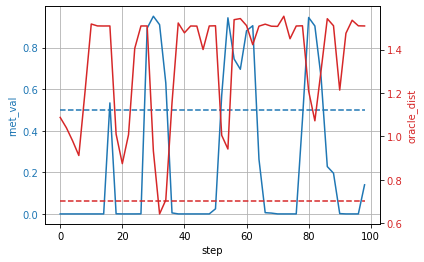

oracle_distance: 1.509
oracle_success: False


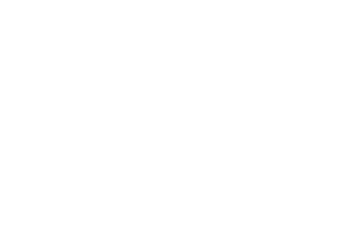

In [345]:
info, video = generate_episode_walker(env, goal_idx=8, vis=True, plot=True)

print(f'oracle_distance: {round(info["oracle_distance"], 3)}')
print(f'oracle_success: {bool(info["oracle_success"])}')


imw = video.shape[2]
video[:, :, imw //2-1 : imw//2+1] = 0
fig = plt.figure()
plt.axis('off')
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=video.shape[0],interval=150, repeat=False
)
plt.axis('off')
HTML(anim.to_jshtml())

In [247]:
memory = RNetMemory(cfg.rnet.memory, space_info, cfg.rnet.model.feat_size, device)
_ = memory.load(f'{logs_dir}{exp_name}/memory.npy')

goals = memory.get_goals()
env.set_goals(goals)

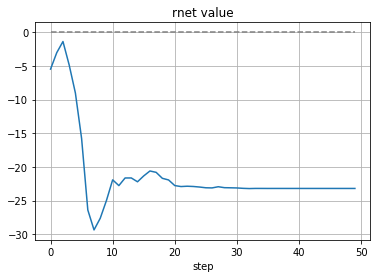

oracle_distance: 2.059
oracle_success: False


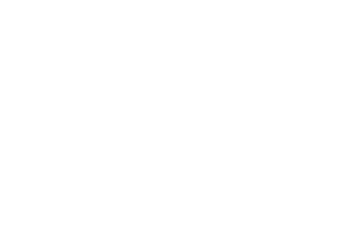

In [248]:
info, video = generate_episode_walker(env, goal_idx=None, vis=True, rnet_val=True)

print(f'oracle_distance: {round(info["oracle_distance"], 3)}')
print(f'oracle_success: {bool(info["oracle_success"])}')


imw = video.shape[2]
video[:, :, imw //2-1 : imw//2+1] = 0
fig = plt.figure()
plt.axis('off')
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=150, repeat=False)
plt.axis('off')
HTML(anim.to_jshtml())